# Feature Importance

### This Notebook computes the importance of each feature and sorts them according to these values

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

### Functions

These functions compute the labels, aggregate the feature- and annotation-dataframes and fnally stack them all together.

In [2]:
def get_label(arousal: int, valence: int) -> str:
    """
    Computes and returns label for each arousal-valence pair"""
    if valence > 0 and arousal >= 3:
        return "Happy"
    elif valence <= 0 and arousal > 3:
        return "Angry"
    elif valence < 0 and arousal <= 3:
        return "Sad"
    elif valence >= 0 and arousal < 3:
        return "Relaxed"
    else:
        return "Unknown"

def aggregate_all_anot(anot_df: pd.DataFrame) -> pd.DataFrame:
    """
    Aggregates all anot-features from each sample with the same pianist-segment pairs 
    and returns this compressed dataframe.
    """
    anot_df = anot_df.copy()
    anot_df = anot_df.dropna()
    anot_df = anot_df.groupby(['pianist_id', 'segment_id']).agg('mean')
    anot_df = anot_df.drop(['annotator_id'], axis=1)
    return anot_df

def aggregate_all_feat(feat_df: pd.DataFrame) -> pd.DataFrame:
    """
    Aggregates all feat-features from each sample with the same pianist-segment pairs 
    and returns this compressed dataframe. 
    """
    feat_df = feat_df.copy()
    feat_df = feat_df.dropna()
    feat_df = feat_df.groupby(['pianist_id', 'segment_id']).agg('mean')
    feat_df = feat_df.drop(['snippet_id'], axis=1)
    return feat_df

def combine_dfs(anot_df: pd.DataFrame, feat_df: pd.DataFrame) -> pd.DataFrame:
    """
    Merges the 2 dfs
    """
    anot_df = anot_df.copy()
    feat_df = feat_df.copy()
    df = pd.concat([anot_df, feat_df], axis=1)
    return df

def aggregate_labels(df: pd.DataFrame) -> pd.DataFrame:
    """
    Computes labels and adds them to the df
    """
    df = df.copy()
    labels = []
    column_names = list(df.columns)
    arousal_col_idx = column_names.index("arousal")
    valence_col_idx = column_names.index("valence")
    
    for sample in df.values:
        arousal_agg = sample[arousal_col_idx]
        valance_agg = sample[valence_col_idx]
        labels.append(get_label(arousal_agg, valance_agg))
    
    df["label"] = labels
    return df

def prep_df(anot_df: pd.DataFrame, feat_df: pd.DataFrame) -> pd.DataFrame:
    """
    This functon takes the 2 'raw' data-frames (annot. and feat.) as input
    and returns a fully combined, aggregated and labled dataframe
    - ready for RandomForest
    """
    anot_df = anot_df.copy()
    feat_df = feat_df.copy()
    # first aggregate the "high level features" from the annotations-file
    agg_anot = aggregate_all_anot(anot_df)
    # next aggregate the musical features from the features-file 
    agg_feat = aggregate_all_feat(feat_df)
    # and merge the 2 dfs
    merged_df = combine_dfs(agg_anot, agg_feat)
    # last compute labels and add them to the df
    labled_df = aggregate_labels(merged_df)
    
    return labled_df
    

### Import data

Here the data from the csv files is read, as well as the NaN-values dropped.

In [3]:
anot = pd.read_csv("data/task_2_annotations.csv")
anot = anot.dropna()
anot.head()

,pianist_id,segment_id,annotator_id,arousal,valence,gems_wonder,gems_transcendence,gems_tenderness,gems_nostalgia,gems_peacefulness,gems_power,gems_joyful_activation,gems_tension,gems_sadness,gemmes_flow,gemmes_movement,gemmes_force,gemmes_interior,gemmes_wandering
0,1,0,91,1,-1,2,1,2,4,2.0,1,1,1,2,3,2,1,1.0,2
1,1,0,19,2,-1,3,3,3,4,4.0,1,2,3,3,3,2,2,3.0,3
2,1,0,189,2,0,2,1,2,1,4.0,2,2,1,1,3,2,1,1.0,4
3,1,0,126,2,2,4,5,2,3,5.0,2,4,1,3,5,1,2,2.0,5
4,1,0,26,4,2,3,5,2,3,3.0,1,3,4,1,4,1,2,3.0,1


In [4]:
feat = pd.read_csv("data/task_2_features.csv")
feat = feat.dropna()
feat.head()

,pianist_id,segment_id,snippet_id,essentia_dissonance_mean,essentia_dissonance_stdev,essentia_dynamic_complexity,essentia_loudness,essentia_onset_rate,essentia_pitch_salience_mean,essentia_pitch_salience_stdev,...,mirtoolbox_novelty_std,mirtoolbox_novelty_pct_10,mirtoolbox_novelty_pct_50,mirtoolbox_novelty_pct_90,mirtoolbox_pulseclarity,mirtoolbox_roughness_mean,mirtoolbox_roughness_std,mirtoolbox_roughness_pct_10,mirtoolbox_roughness_pct_50,mirtoolbox_roughness_pct_90
0,1,0,0,0.192237,0.059404,2.040252,16079768.0,0.8,0.677256,0.095846,...,0.106446,0.00000,0.013819,0.082176,0.169743,0.011449,0.004161,0.006684,0.011048,0.017025
1,1,0,1,0.143425,0.064204,3.138845,35489248.0,2.6,0.514913,0.092372,...,0.193342,0.00000,0.027786,0.356029,0.355861,0.006205,0.003194,0.002583,0.005657,0.010610
2,1,0,2,0.146967,0.056205,2.019706,42130144.0,2.6,0.560116,0.115359,...,0.218179,0.00000,0.049050,0.375251,0.209162,0.007467,0.003986,0.002330,0.007206,0.012690
3,1,0,3,0.158810,0.059129,3.567908,40922732.0,1.4,0.596779,0.116061,...,0.118148,0.00002,0.017653,0.098657,0.232454,0.007335,0.004063,0.002609,0.006807,0.012971
4,1,0,4,0.168547,0.049648,2.329854,51921612.0,1.6,0.556160,0.143420,...,0.121018,0.00000,0.020525,0.157408,0.140930,0.007345,0.003917,0.002662,0.007016,0.012731


### Apply functions

Here the functions from above are actually used on the loaded data

In [5]:
labled_df = prep_df(anot, feat)
labled_df

arousal   valence  gems_wonder  gems_transcendence  \
pianist_id segment_id                                                        
1          0           2.909091  0.181818     3.272727            3.181818   
           1           3.875000  0.000000     3.375000            3.250000   
           2           2.909091  0.181818     2.818182            2.545455   
           3           3.000000 -0.250000     1.875000            1.750000   
           4           3.000000 -0.181818     2.727273            2.636364   
...                         ...       ...          ...                 ...   
11         22          2.181818  0.090909     2.727273            1.545455   
           23          3.166667  0.000000     2.833333            2.833333   
           24          2.000000 -0.181818     2.454545            1.636364   
           25          1.833333  0.000000     2.833333            2.000000   
           26          2.909091  0.181818     3.090909            1.909091   

                       gems_tenderness  gems_nostalgia  gems_peacefulness  \
pianist_id segment_id                                                       
1          0                  2.909091        3.727273           3.454545   
           1                  2.125000        2.375000           1.750000   
           2                  1.636364        1.545455           1.545455   
           3                  1.375000        1.750000           1.375000   
           4                  2.545455        2.545455           2.272727   
...                                ...             ...                ...   
11         22                 3.272727        2.818182           3.454545   
           23                 1.666667        2.000000           1.333333   
           24                 3.272727        3.818182           3.636364   
           25                 1.833333        3.500000           2.833333   
           26                 1.454545        2.363636           1.818182   

                       gems_power  gems_joyful_activation  gems_tension  ...  \
pianist_id segment_id                                                    ...   
1          0             2.090909                2.363636      2.090909  ...   
           1             2.375000                2.875000      2.625000  ...   
           2             2.909091                3.000000      3.363636  ...   
           3             2.625000                1.500000      3.375000  ...   
           4             2.363636                1.454545      2.727273  ...   
...                           ...                     ...           ...  ...   
11         22            1.454545                2.090909      1.636364  ...   
           23            3.000000                1.666667      2.666667  ...   
           24            1.181818                1.909091      1.636364  ...   
           25            1.333333                1.333333      1.500000  ...   
           26            2.636364                2.545455      2.272727  ...   

                       mirtoolbox_novelty_pct_10  mirtoolbox_novelty_pct_50  \
pianist_id segment_id                                                         
1          0                        1.780861e-06                   0.022972   
           1                        0.000000e+00                   0.038582   
           2                        0.000000e+00                   0.060005   
           3                        0.000000e+00                   0.042309   
           4                        0.000000e+00                   0.048413   
...                                          ...                        ...   
11         22                       8.297538e-07                   0.021185   
           23                       1.098596e-03                   0.030785   
           24                       6.933548e-05                   0.023485   
           25                       1.382490e-05                   0.028203   
           26     

### Random Forest

Last, a `RandomForest` is used to find out, which of the given features are the most important ones for classification. Because the `RandomForest` and `train_test_split` methods both involve _random elements_, the results are computed numerous times before _averaging_ and finally sorting them.

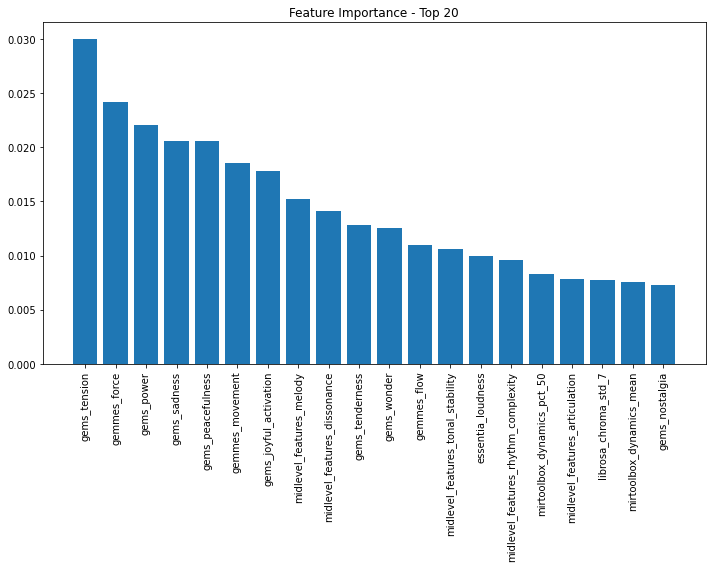

In [7]:
num_iterations = 100
feat_imp_array = []

# Split data, scale and compute feature importances
for i in range(num_iterations):

    X_train, _, y_train, _ = train_test_split(labled_df.iloc[:, 2:-1], # we don't want arousal and valence as fetures
                                              labled_df.iloc[:, -1:], 
                                              test_size=0.01
                                             )
    
    # we use the normalized versions of all features
    sc = StandardScaler()
    sc.fit(X_train)
    X_test = pd.DataFrame(sc.transform(X_train), columns=labled_df.columns[2:-1])
    X_test = pd.DataFrame(sc.transform(X_test), columns=labled_df.columns[2:-1])
    
    # Random Forest
    rf_cls = RandomForestClassifier()
    rf_cls.fit(X_train, y_train.values.ravel())
    feature_importance = rf_cls.feature_importances_
    feat_imp_array.append(feature_importance)

# computing mean of all the feature importances
feat_imp_array = np.array(feat_imp_array)
mean_feat_imp = np.mean(feat_imp_array, axis=0)
sort_indices = np.argsort(mean_feat_imp)[::-1]
mean_feat_imp = mean_feat_imp[sort_indices]

# choosing only the top 20 to avoid overplotting
top_feat = 20
sort_indices = sort_indices[:top_feat]
mean_feat_imp = mean_feat_imp[:top_feat]
n_features = len(mean_feat_imp)

# plotting the results
fig, _ = plt.subplots(figsize=(10, 8))
plt.title(f'Feature Importance - Top {top_feat}')
plt.bar(range(n_features), mean_feat_imp, align='center')
plt.xticks(range(n_features), X_train.columns[sort_indices], rotation=90)
plt.tight_layout()
plt.show()

# Result

This average result shows, that ***gems_tension*** is by quite some margin the most important feature, followed by ***gemmes_force*** and ***gems_power***. It may be due to the fact, that all these metaphors have a very distinct sound and are thus better classifiable, as well as better representable in valence-arousal pairs.

It is also interesting to see, that these "high-level" features seem to be more important for classification than the features computed from the spectrograms, with the first "non-high-level" feature on rank 8. 